Exercise-based on a dataset published on Kaggle: https://www.kaggle.com/chrizzles/swiss-banknote-conterfeit-detection

**Goal:** Finding a model which can identify genuine and conterfeit banknotes.

**Propouse:**
- Accomplishing an exploratory data analysis on the dataset.
- Identifying and dealing with possible skewed data, where applicable.
- Accomplishing hypothesis tests by analyzing data variation, where applicable.
- Accomplishing normality tests.
- Identifying possible correlations.
- Accomplishing oversampling or undersampling techniques to solve possible imbalance problem, if necessary.
- Solving possible overfitting and underfitting problems, if necessary.
- Accomplishing data normalization and coeficient regularization techniques, if necessary.
- Accomplishing attribute selection, if neecssary.
- Finding which algorithm have the best performance: Naïve Bayes, Logistic Regression, Tree Decision, Random Forest, and SVC
- Applying K-Fold cross-validation.
- Validating results with confusion matrix
- Checking algorithms' results variability.

**Solution author's Linkedin profile:** https://bit.ly/3tsOnU3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
import itertools
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import skewnorm
from scipy.stats import shapiro
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore")
abs_path = os.getcwd()

# 1. Get dataset by Kaggle API

In [2]:
parquet_file = "banknotes.parquet"
csv_file = "banknotes.csv"
zip_file = "swiss-banknote-conterfeit-detection.zip"

if os.path.isfile(parquet_file):
    print ("There is a parquet file!!!")
    dataset = pd.read_parquet(parquet_file)
else:
    """
    Get the compressed dataset (.zip file), 
    Extract .csv file,
    Deletr .zip file,
    Load .csv jupyter to jupyter notebook,
    Delete .csv file,
    Generate .parquet file
    """
    print ("There is no file")
    !kaggle datasets download -d chrizzles/swiss-banknote-conterfeit-detection
    with zipfile.ZipFile(zip_file,"r") as zip_ref:
        zip_ref.extractall(abs_path)
    os.remove(zip_file)
    dataset = pd.read_csv(csv_file)
    dataset.to_parquet(parquet_file, engine='pyarrow')
    os.remove(csv_file)
    
dataset

There is a parquet file!!!


,conterfeit,Length,Left,Right,Bottom,Top,Diagonal
0,0,214.8,131.0,131.1,9.0,9.7,141.0
1,0,214.6,129.7,129.7,8.1,9.5,141.7
2,0,214.8,129.7,129.7,8.7,9.6,142.2
3,0,214.8,129.7,129.6,7.5,10.4,142.0
4,0,215.0,129.6,129.7,10.4,7.7,141.8
...,...,...,...,...,...,...,...
195,1,215.0,130.4,130.3,9.9,12.1,139.6
196,1,215.1,130.3,129.9,10.3,11.5,139.7
197,1,214.8,130.3,130.4,10.6,11.1,140.0
198,1,214.7,130.7,130.8,11.2,11.2,139.4


# 2. Exploratory Data Analysis

**Analysis:** By getting "non-null" results below, it proves:
- There is no null data, so there is no need to delete elements/columns or to add data by interpolation.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   conterfeit  200 non-null    int64  
 1   Length      200 non-null    float64
 2   Left        200 non-null    float64
 3   Right       200 non-null    float64
 4   Bottom      200 non-null    float64
 5   Top         200 non-null    float64
 6   Diagonal    200 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 11.1 KB


**Analysis:** The data below proves that some normalization technique is needed on explicative variables and they are also continuous.

In [4]:
dataset.describe()

,conterfeit,Length,Left,Right,Bottom,Top,Diagonal
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.500000,214.896000,130.121500,129.956500,9.417500,10.650500,140.483500
std,0.501255,0.376554,0.361026,0.404072,1.444603,0.802947,1.152266
min,0.000000,213.800000,129.000000,129.000000,7.200000,7.700000,137.800000
25%,0.000000,214.600000,129.900000,129.700000,8.200000,10.100000,139.500000
50%,0.500000,214.900000,130.200000,130.000000,9.100000,10.600000,140.450000
75%,1.000000,215.100000,130.400000,130.225000,10.600000,11.200000,141.500000
max,1.000000,216.300000,131.000000,131.100000,12.700000,12.300000,142.400000


**Analysis:** The response variable, 'conterfeit', is perfect balanced between its classes. So there is no need of using undersampling or oversampling techniques.

In [5]:
np.unique(dataset['conterfeit'], return_counts=True)

(array([0, 1], dtype=int64), array([100, 100], dtype=int64))

**Analysis:** The distribution graphics below proves that data normalization is need to some explicative variables, as well as, it shows some different kind of distributions: bimodal, normal, left and tight skewed.

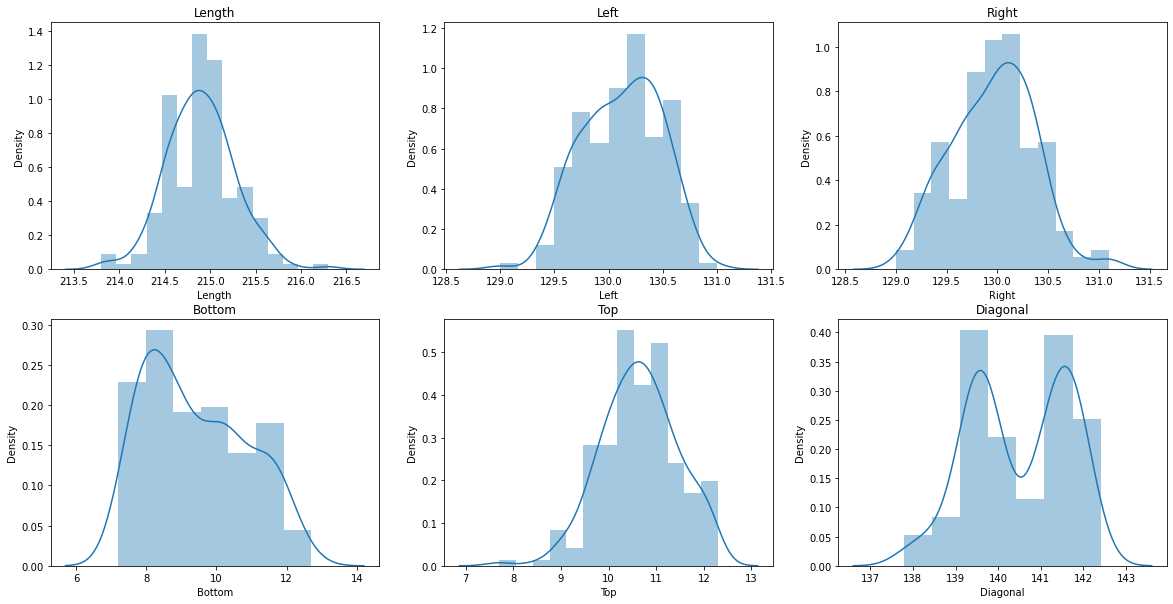

In [6]:
x = dataset.iloc[:,1:]
y = dataset.iloc[:,:1]

plt.figure(figsize=(20,10))
for count, column in enumerate(x.columns):
    plt.subplot(2, len(x.columns)/2, count+1)
    plt.title(column)
    plt.subplot(sns.distplot(dataset[column]))
plt.show()
plt.close()

**Analysis:** The box plots below described some outliers.

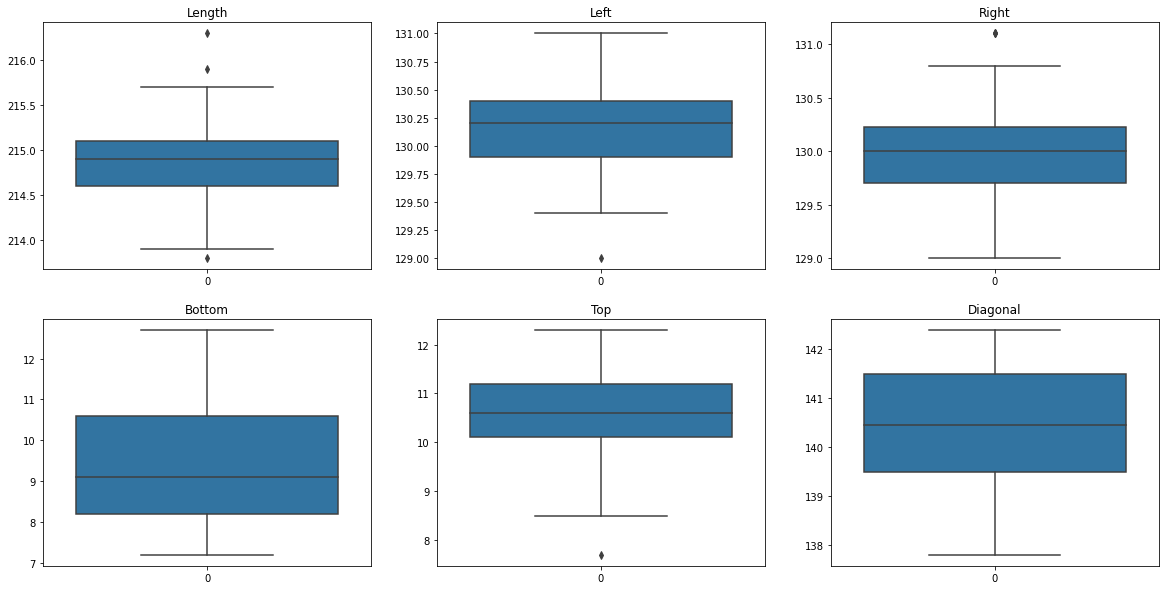

In [7]:
plt.figure(figsize=(20,10))
for count, column in enumerate(x.columns):
    plt.subplot(2, len(x.columns)/2, count+1)
    plt.title(column)
    plt.subplot(sns.boxplot(data=dataset[column]))
plt.show()
plt.close()

**Analysis:** About data normality, some deatils are described below by QQ plots with alpha adjusted to 5%.

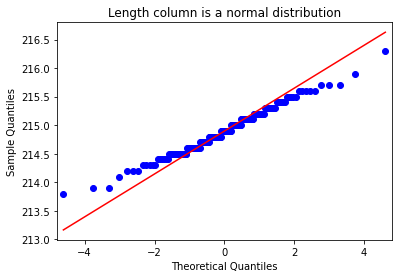

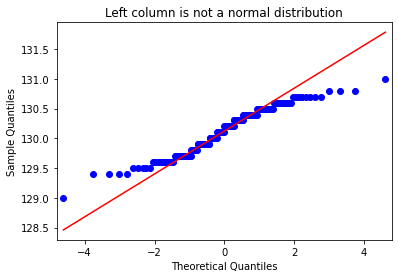

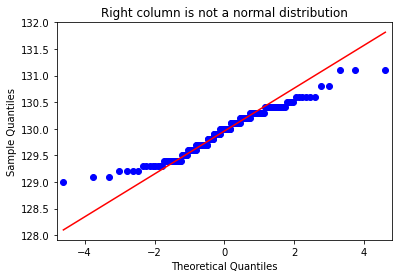

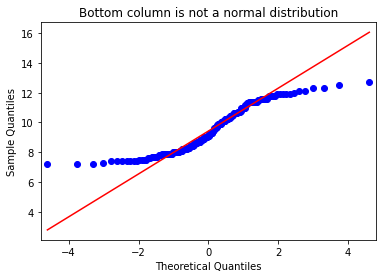

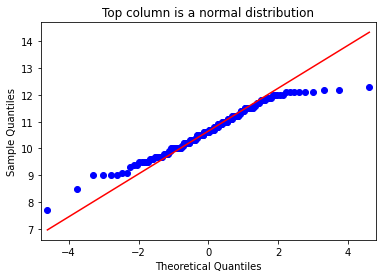

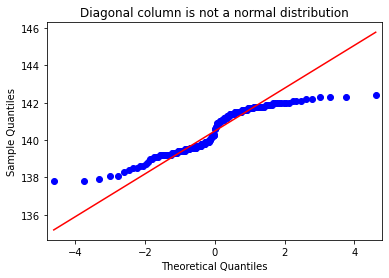

In [8]:
def isNormalDist(column, p):
    alpha = 0.05
    afirmative_text = '{} column is a normal distribution'.format(column)
    negative_text = '{} column is not a normal distribution'.format(column)
    return afirmative_text if p > alpha else negative_text

for column in x.columns:
    _, p = shapiro(dataset[column])
    fig = sm.qqplot(dataset[column], stats.t, distargs=(4,), line = 's')
    plt.title(isNormalDist(column, p))
plt.show()

**Analysis:** From the heatmap of Pearson correlation described below, it can be extracted some conclusios when compare all variables to "conterfeit". According to Evans (1996 - "Evans JD (1996) Straight forward statistics for the behavioral sciences. Brooks/Cole Pub. Co, Pacific Grove", also http://leg.ufpr.br/~silvia/CE003/node74.html - in portuguese) classification for Pearson correlation, follow below the conclusions about the correlation between all variables and variable "conterfeit":
- Very strong: Diagonal
- Strong: Bottom
- Moderate: Left, Right, Top
- Very weak: Lenght

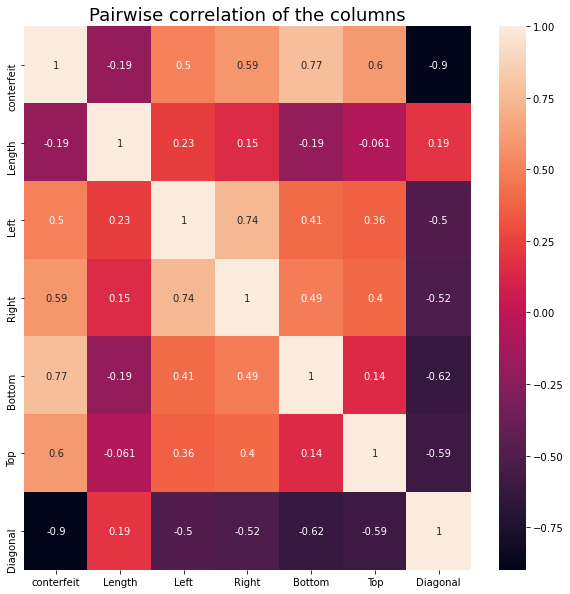

In [9]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.title("Pairwise correlation of the columns", fontsize = 18)
ax = sns.heatmap(dataset.corr(), annot = True)

**Analysis:** In addition, the Scatter and Distributions plot below show that variable "Diagonal" strongly explain the variable "conterfeit".

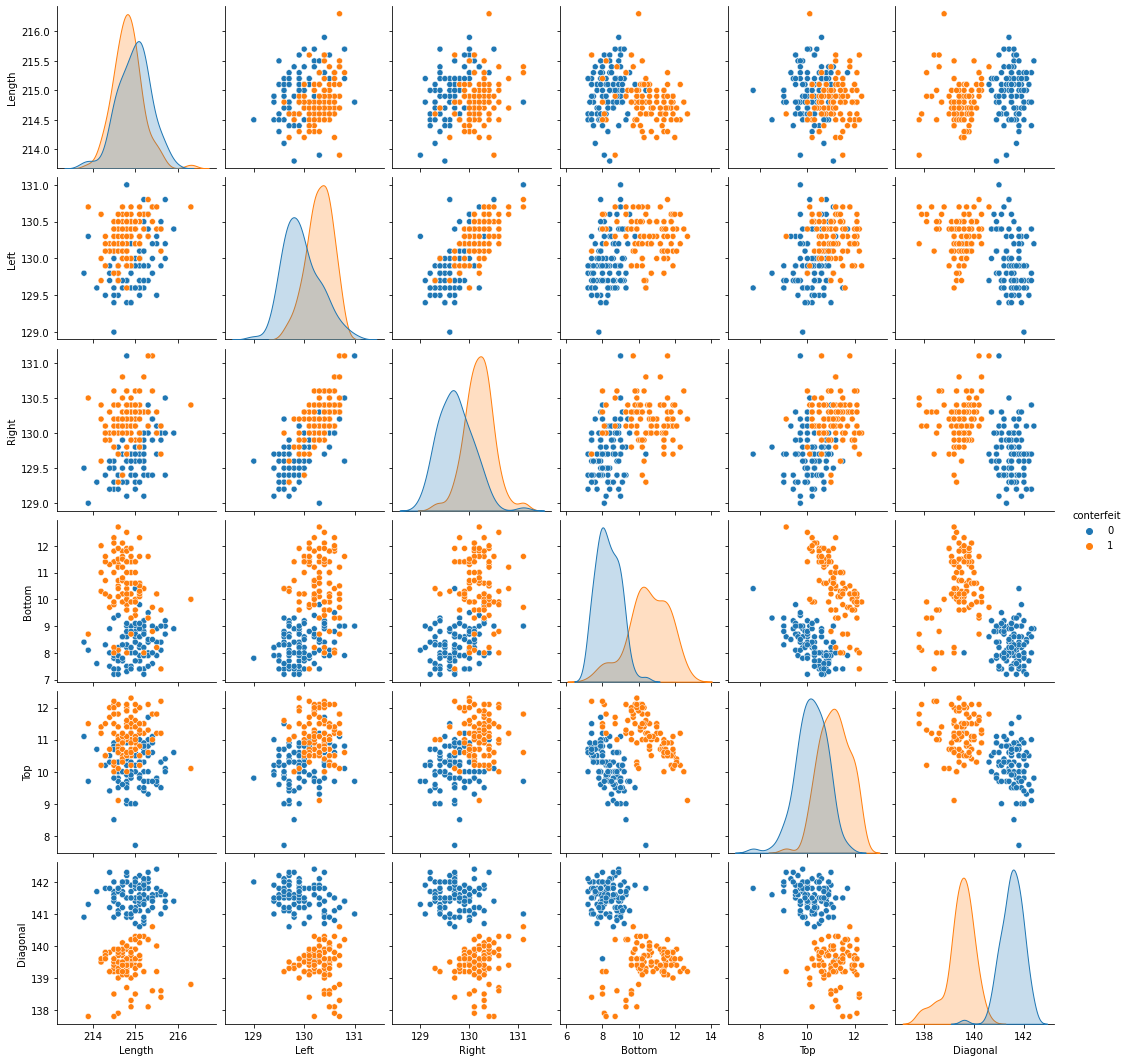

In [10]:
sns.pairplot(dataset, hue = "conterfeit")
plt.show()

# 3. Model train - With skewed data and no attribute selection

**Explicative variables**

In [11]:
x.head()

,Length,Left,Right,Bottom,Top,Diagonal
0,214.8,131.0,131.1,9.0,9.7,141.0
1,214.6,129.7,129.7,8.1,9.5,141.7
2,214.8,129.7,129.7,8.7,9.6,142.2
3,214.8,129.7,129.6,7.5,10.4,142.0
4,215.0,129.6,129.7,10.4,7.7,141.8


**Response variable**

In [12]:
y.head()

,conterfeit
0,0
1,0
2,0
3,0
4,0


Accuracy Mean:
	Naïve Bayes              : 0.99111%
	Logistic Regression      : 0.99278%
	Random Forest            : 0.99056%
	Decision Tree            : 0.97667%
	SVC                      : 0.98944%
	kNN                      : 0.98722%
Standard deviation:
	Naïve Bayes              : 0.0093624
	Logistic Regression      : 0.0082589
	Random Forest            : 0.010259
	Decision Tree            : 0.014011
	SVC                      : 0.010077
	kNN                      : 0.013391
Coefficient of variation:
	Naïve Bayes              : 0.0094464
	Logistic Regression      : 0.008319
	Random Forest            : 0.010357
	Decision Tree            : 0.014345
	SVC                      : 0.010184
	kNN                      : 0.013564


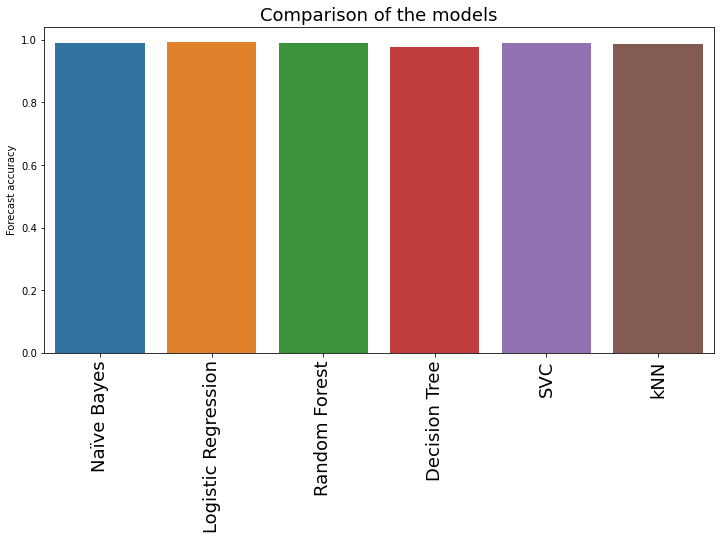

Confidence interval - Naïve Bayes         : (0.9877036119546867, 0.9945186102675356)
Confidence interval - Logistic Regression : (0.9897718902680939, 0.9957836652874621)
Confidence interval - Random Forest       : (0.9868217321267675, 0.994289378984344)
Confidence interval - Decision Tree       : (0.9715674302840879, 0.981765903049245)
Confidence interval - SVC                 : (0.985776907174052, 0.9931119817148372)
Confidence interval - kNN                 : (0.9823484564553482, 0.9920959879890965)


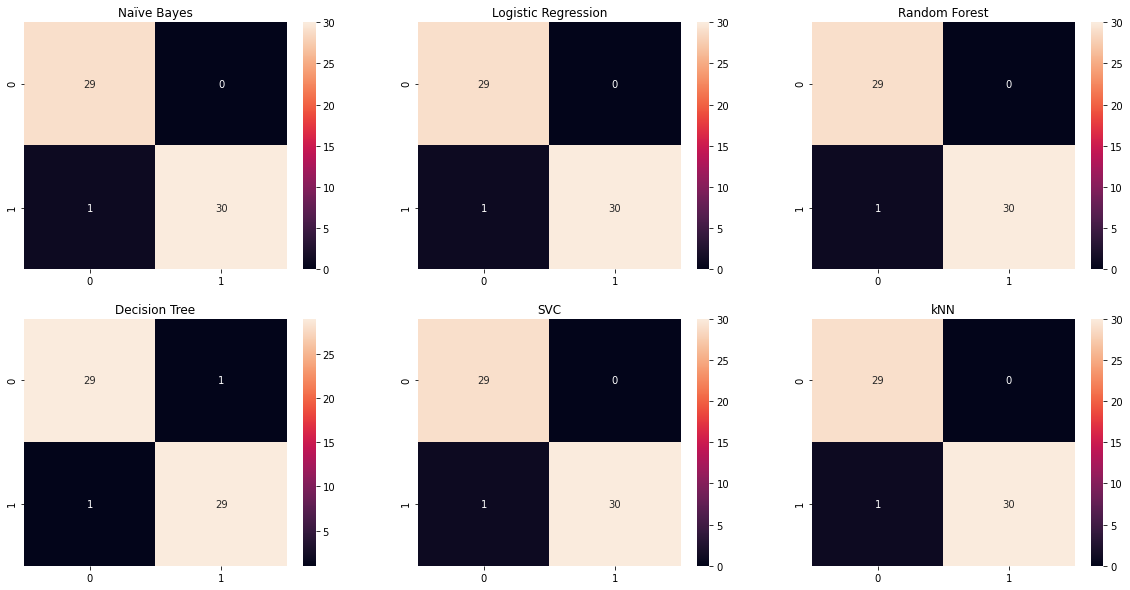

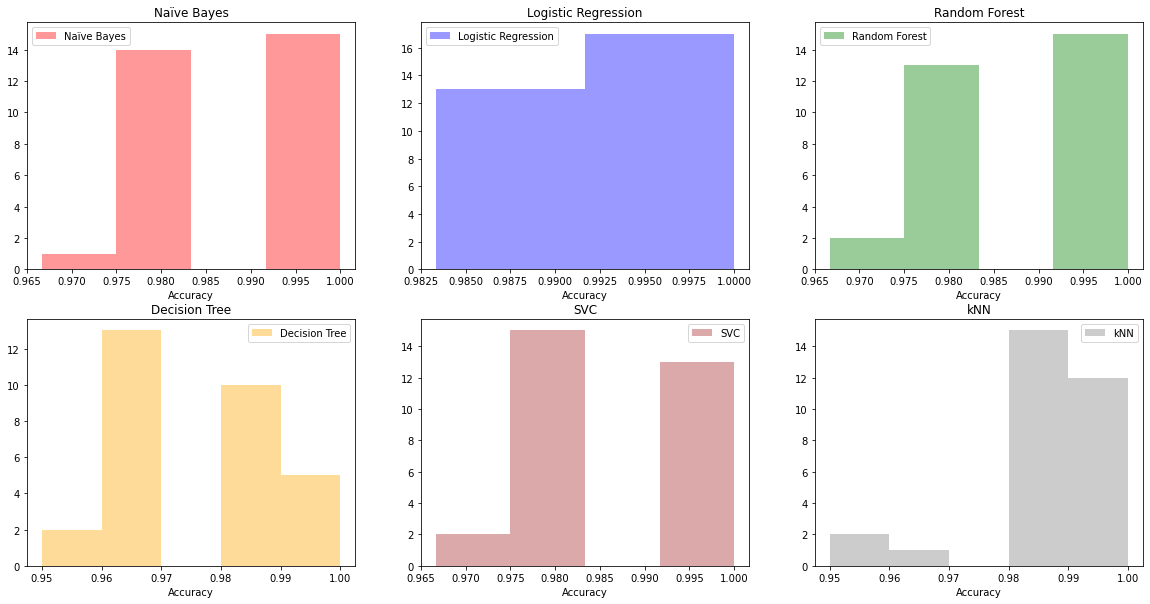

In [13]:
def train(x, y, train_loop):
    resultados_naive_bayes = []
    resultados_logistica = []
    resultados_forest = []
    resultados_decision_tree = []
    resultados_svc = []
    resultados_knn = []
    
    previsao_naive_bayes = 0
    previsao_logistica = 0
    previsao_forest = 0
    previsao_decision_tree = 0
    previsao_svc = 0
    previsao_knn = 0
    naive_bayes, logistica, random_forest, decision_tree, svc, knn = None, None, None, None, None, None
    
    for i in range(train_loop):
        x_train, x_test, y_train, y_test = train_test_split(x, 
                                                            y, 
                                                            test_size=0.3,
                                                            stratify = y,
                                                            random_state = i)
        # data normalization during training
        st = StandardScaler()
        x_train = st.fit_transform(x_train)
        x_test = st.fit_transform(x_test)

        naive_bayes = GaussianNB()
        naive_bayes.fit(x_train, y_train)
        previsao_naive_bayes = naive_bayes.predict(x_test)
        resultados_naive_bayes.append(accuracy_score(y_test, previsao_naive_bayes))

        logistica = LogisticRegression()
        logistica.fit(x_train, y_train)
        previsao_logistica = logistica.predict(x_test)
        resultados_logistica.append(accuracy_score(y_test, previsao_logistica))

        random_forest = RandomForestClassifier()
        random_forest.fit(x_train, y_train)
        previsao_forest = random_forest.predict(x_test)
        resultados_forest.append(accuracy_score(y_test, previsao_forest))
        
        decision_tree = DecisionTreeClassifier()
        decision_tree.fit(x_train, y_train)
        previsao_decision_tree = decision_tree.predict(x_test)
        resultados_decision_tree.append(accuracy_score(y_test, previsao_decision_tree))
        
        svc = SVC()
        svc.fit(x_train, y_train)
        previsao_svc = svc.predict(x_test)
        resultados_svc.append(accuracy_score(y_test, previsao_svc))
        
        knn = KNeighborsClassifier()
        knn.fit(x_train, y_train)
        previsao_knn = knn.predict(x_test)
        resultados_knn.append(accuracy_score(y_test, previsao_knn))
        
    return [[
                np.array(resultados_naive_bayes), 
                np.array(resultados_logistica), 
                np.array(resultados_forest),
                np.array(resultados_decision_tree),
                np.array(resultados_svc),
                np.array(resultados_knn),
            ],
            [
                previsao_naive_bayes,
                previsao_logistica,
                previsao_forest,
                previsao_decision_tree,
                previsao_svc,
                previsao_knn,
            ],
            [
                naive_bayes, 
                logistica, 
                random_forest, 
                decision_tree, 
                svc, 
                knn
            ],
            y_test]

def plot_algorithms_scores_comparison(algoritmos, scores):
    plt.figure(figsize = (12,6)) 
    mean_score_list = []
    [mean_score_list.append(algor_score_list.mean()) for algor_score_list in scores]
    ax = sns.barplot(algoritmos, mean_score_list)
    ax.set_xticklabels(algoritmos, fontsize = 18, rotation = 90)
    plt.title("Comparison of the models", fontsize = 18)
    plt.ylabel("Forecast accuracy")
    plt.show()
    plt.close()
    
def calculate_plot_confusion_matrix(previsoes, y_test, algoritmos):
    plt.figure(figsize=(20,10))
    for index, (score,algoritmo) in enumerate(zip(list(previsoes),algoritmos)):
        plt.subplot(2, len(previsoes)/2, index+1)
        plt.title(algoritmo)
        plt.subplot(sns.heatmap(confusion_matrix(previsoes[index], y_test), annot=True))
        
def plot_confusion_matrix(matrix, algoritmos):
    plt.figure(figsize=(20,10))
    for index, (score,algoritmo) in enumerate(zip(list(matrix),algoritmos)):
        plt.subplot(2, len(matrix)/2, index+1)
        plt.title(algoritmo)
        plt.subplot(sns.heatmap(matrix[index], annot=True))
    
def plot_scores_distplot(scores, algoritmos):
    plt.figure(figsize=(20,10))
    colors = ["red", "blue", "green", "orange", "brown", "gray"]

    for (index,(score,algoritmo)), color in zip(enumerate(zip(list(scores),algoritmos)), colors):
        plt.subplot(2, len(scores)/2, index+1)
        plt.title(algoritmo)
        plt.subplot(sns.distplot(score, color=color, label=algoritmo, hist=True, kde=False, axlabel="Accuracy"))
        plt.legend();
    
def plot_confidence_interval(scores, algoritmos):
    for score,algoritmo in zip(list(scores),algoritmos):
        print("Confidence interval - {:<20}: {}".format(algoritmo, norm.interval(0.95, score.mean(),stats.sem(score))))
        
def plot_statistics(scores, algoritmos):
    print("Accuracy Mean:")
    for score,algoritmo in zip(list(scores),algoritmos):
        print("\t{:<25}: {:.5}%".format(algoritmo, score.mean()))
    print("Standard deviation:")
    for score,algoritmo in zip(list(scores),algoritmos):
        print("\t{:<25}: {:.5}".format(algoritmo, np.std(score)))
    print("Coefficient of variation:")
    for score,algoritmo in zip(list(scores),algoritmos):
        print("\t{:<25}: {:.5}".format(algoritmo, stats.variation(score)))
    
def train_and_plot_anslysis(x, y):
    train_loop = 30
    results = train(x, y, train_loop)
    algoritmos = ["Naïve Bayes", "Logistic Regression", "Random Forest", "Decision Tree", "SVC", "kNN"]
    
    # Mean, Standard Deviation, and Coefficient of variation
    plot_statistics(results[0], algoritmos)
    
    # Models results' comparison
    plot_algorithms_scores_comparison(algoritmos, results[0])
    
    # Confidence interval
    plot_confidence_interval(results[0], algoritmos)
    
    # Confusion Matrix
    calculate_plot_confusion_matrix(results[1], results[3], algoritmos)
        
    # Results Variation
    plot_scores_distplot(results[0], algoritmos)
    
train_and_plot_anslysis(x, y)

# 4. Models validation with K-Fold - With skewed data and no attribute selection

Accuracy Mean:
	Naïve Bayes              : 0.99433%
	Logistic Regression      : 0.995%
	Random Forest            : 0.99183%
	Decision Tree            : 0.98017%
	SVC                      : 0.51917%
	kNN                      : 0.99517%
Standard deviation:
	Naïve Bayes              : 0.0016997
	Logistic Regression      : 1.1102e-16
	Random Forest            : 0.0024095
	Decision Tree            : 0.0055503
	SVC                      : 0.073384
	kNN                      : 0.00089753
Coefficient of variation:
	Naïve Bayes              : 0.0017094
	Logistic Regression      : 1.1158e-16
	Random Forest            : 0.0024293
	Decision Tree            : 0.0056626
	SVC                      : 0.14135
	kNN                      : 0.00090189


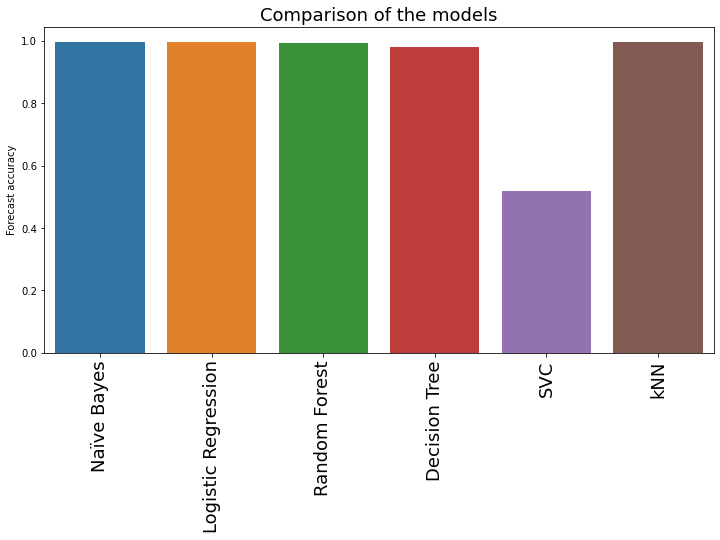

Confidence interval - Naïve Bayes         : (0.9937147267873232, 0.9949519398793432)
Confidence interval - Logistic Regression : (0.995, 0.995)
Confidence interval - Random Forest       : (0.9909563911027444, 0.9927102755639221)
Confidence interval - Decision Tree       : (0.9781466097101869, 0.9821867236231469)
Confidence interval - SVC                 : (0.492458286679011, 0.5458750466543223)
Confidence interval - kNN                 : (0.9948400060025766, 0.9954933273307567)


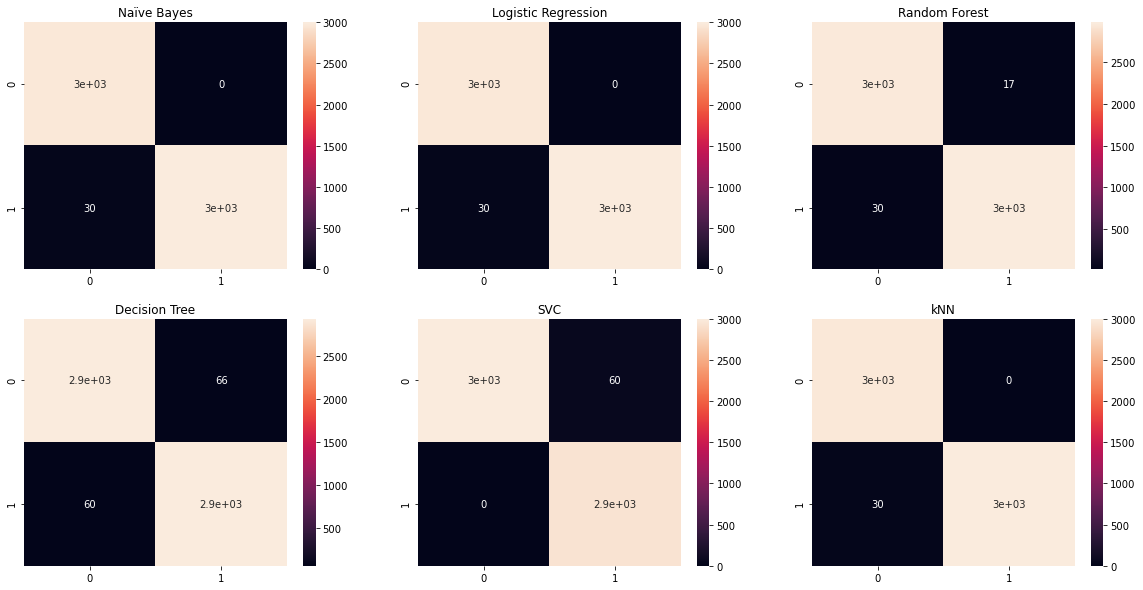

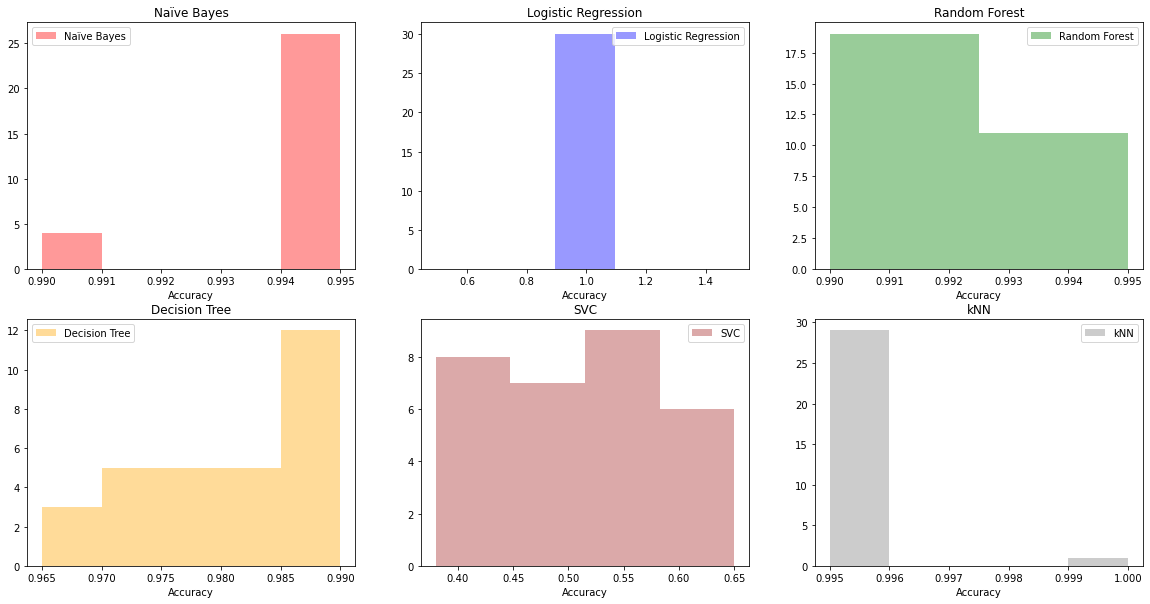

In [14]:
def train_kfold(x, y, train_loop):
    resultados_naive_bayes = []
    resultados_logistic = []
    resultados_forest = []
    resultados_decision_tree = []
    resultados_svc = []
    resultados_knn = []
    confusion_kfold = []

    for i in range(train_loop):
        kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
        
        modelos = [GaussianNB(), 
                   LogisticRegression(), 
                   RandomForestClassifier(), 
                   DecisionTreeClassifier(), 
                   SVC(),
                   KNeighborsClassifier()]

        scores = cross_val_score(modelos[0], x, y, cv = kfold)
        resultados_naive_bayes.append(scores.mean())

        scores = cross_val_score(modelos[1], x, y, cv = kfold)
        resultados_logistic.append(scores.mean())

        scores = cross_val_score(modelos[2], x, y, cv = kfold)
        resultados_forest.append(scores.mean())
        
        scores = cross_val_score(modelos[3], x, y, cv = kfold)
        resultados_decision_tree.append(scores.mean())
        
        scores = cross_val_score(modelos[4], x, y, cv = kfold)
        resultados_svc.append(scores.mean())
        
        scores = cross_val_score(modelos[5], x, y, cv = kfold)
        resultados_knn.append(scores.mean())
        
        if i == 0:
            [confusion_kfold.append(confusion_matrix(cross_val_predict(modelo, x, y, cv=10), y)) for modelo in modelos]
        else:
            for index, modelo in enumerate(modelos):
                confusion_kfold[index] = confusion_kfold[index] + confusion_matrix(cross_val_predict(modelo, x, y, cv=10), y)
    
    return [[np.array(resultados_naive_bayes), 
            np.array(resultados_logistic), 
            np.array(resultados_forest),
            np.array(resultados_decision_tree),
            np.array(resultados_svc),
            np.array(resultados_knn)],
            confusion_kfold]

def train_and_plot_kfold_analysis(x, y):
    algoritmos = ["Naïve Bayes", "Logistic Regression", "Random Forest", "Decision Tree", "SVC", "kNN"]
    train_loop = 30
    
    results_kfold = train_kfold(x, y, train_loop)   

    # Mean, Standard Deviation, and Coefficient of variation
    plot_statistics(results_kfold[0], algoritmos)
    
    # Models results' comparison
    plot_algorithms_scores_comparison(algoritmos, results_kfold[0])

    # Confidence interval
    plot_confidence_interval(results_kfold[0], algoritmos)
    
    # Confusion Matrix
    plot_confusion_matrix(results_kfold[1], algoritmos)

    # Results Variation
    plot_scores_distplot(results_kfold[0], algoritmos)
        
train_and_plot_kfold_analysis(x, y)

# 5. Conclusion

Even with no data transformation for skewed data, a good result was achieved with both algorithms during tests, on step 3, using 30 train loops. 
But, during K-Fold cross-validation, on step 4, just SVC algorithm achieved a real different result from step 3. On the 4 one, SVC reached a lower result.
Other algorithms reached a good result on cross-validation, a special consideration for Logistic Regression which reached the higher result.

In [18]:
!jupyter nbconvert --to html --output "notebook_file" "Swiss Banknote Conterfeit Detection.ipynb" --no-input

[NbConvertApp] Converting notebook Swiss Banknote Conterfeit Detection.ipynb to html
[NbConvertApp] Writing 1625249 bytes to notebook_file.html
